In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline
import os
import re
import sys
import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)

pd.set_option('display.max_rows', 1000)

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 7
plt.rcParams["figure.figsize"] = (6,8)
plt.rcParams["figure.dpi"] = 200
plt.rcParams['svg.fonttype'] = 'none'

sys.path.append(os.path.abspath( '/mnt/c/Users/ochapman/Documents/Mesirov/Software/oscutils'))
import get
try:
    os.mkdir('out')
except:
    pass

In [2]:
# Data locations, change as needed.
data_dir='/mnt/c/Users/ochapman/Documents/Mesirov/medullo_ecDNA/data/FISH'

In [3]:
'''
TODO: Structure data.
class Experiment:
    def __init__(name,):
        pass
'''

def remove_dapi_outliers(df):
    return df[(np.abs(scipy.stats.zscore(df['#_DAPI_pixels'])) < 2)]
def read_counts(subdir):
    file = data_dir+f'/{subdir}/Annotated/nuclei_fish_lsq.csv'
    df = pd.read_csv(file)
    logging.info(f'read {len(df)} nuclei')
    df = remove_dapi_outliers(df)
    logging.info(f'{len(df)} after removing outliers (z > 2)')
    return df
def read_counts_MB268():
    subdir = '20200827_MB268'
    df = read_counts(subdir)
    df['sample'] = 'MB268'
    df['target'] = 'MDM4'
    return df
def read_counts_MB177():
    subdir = '20221024_MB177'
    df = read_counts(subdir)
    df['sample'] = 'MB177'
    df['target'] ='MYCN'
    return df
def read_counts_MB036():
    subdir = '20221024_MB036'
    df = read_counts(subdir)
    df['sample'] = 'MB036'
    df['target'] = 'MYCN'
    return df
def read_counts_RCMB56_x1():
    subdir = '20221025_RCMB56-pdx-DNTTIP2-KMT2E-ETV1aqua'
    df = read_counts(subdir)
    df['sample'] = 'RCMB56_x1'
    df['target'] = None
    return df
def read_counts_RCMB56_p1_region2():
    subdir = '20221024_RCMB56-ht-DNTTIP2-KMT2E-ETV1aqua'
    df = read_counts(subdir)
    df['sample'] = 'RCMB56_p1.2'
    df['target'] = None
    return df
def read_counts_RCMB56_p1_region3():
    subdir = '20221121_RCMB56-ht-DNTTIP2-KMT2E-ETV1aqua'
    df = read_counts(subdir)
    df['sample'] = 'RCMB56-p0'
    df['target']=None
    return df
def read_counts_COLO320HSR():
    subdir = '2022_COLO320HSR_MYC'
    df = read_counts(subdir)
    df['sample'] = 'COLO320HSR'
    df['target']='MYC'
    return df
def read_counts_COLO320DM():
    subdir = 'COLO320DM'
    df = read_counts(subdir)
    df['sample'] = 'COLO320DM'
    df['target'] = 'MYC'
    return df

# wide tables: 1 entry per nucleus.
def read_wide_RCMB56_regions():
    rcmb56_p1_3 = read_counts_RCMB56_p1_region3()
    rcmb56_p1_2 = read_counts_RCMB56_p1_region2()
    df = pd.concat([rcmb56_p1_2,rcmb56_p1_3])
    return df
def read_wide_RCMB56():
    rcmb56_p1_3 = read_counts_RCMB56_p1_region3()
    # rcmb56_p1_2 = read_counts_RCMB56_p1_region2()
    rcmb56_x1 = read_counts_RCMB56_x1()
    df = pd.concat([rcmb56_p1_3,rcmb56_x1])
    return df
def read_wide_FFPE():
    mb268 = read_counts_MB268()
    mb177 = read_counts_MB177()
    mb036 = read_counts_MB036()
    rcmb56 = read_counts_RCMB56_p1_region3()
    colo320hsr = read_counts_COLO320HSR()
    colo320dm = read_counts_COLO320DM()
    df = pd.concat([mb036,mb177,mb268,rcmb56,colo320dm,colo320hsr])
    return df
def read_wide_all():
    df = read_wide_FFPE()
    x1 = read_counts_RCMB56_x1()
    df = pd.concat([df,x1])
    return df


# Long tables: 1 entry per nucleus per probe.

def read_long_Archer():
    '''
    All archer samples are a single red probe.
    '''
    mb268 = read_counts_MB268()
    mb177 = read_counts_MB177()
    mb036 = read_counts_MB036()
    df = pd.concat([mb036,mb177,mb268])
    df = df.rename(columns={'#_FISH_blobs (red)':'value'})
    return df[['sample','target','value']]
def read_long_COLO320():
    colo320hsr = read_counts_COLO320HSR()
    colo320dm = read_counts_COLO320DM()
    df = pd.concat([colo320hsr, colo320dm])
    df = df.rename(columns={'#_FISH_blobs (red)':'value'})
    return df[['sample','target','value']]
def melt(rcmb56_df):
    '''
    Must have columns ['#_FISH_blobs (red)','#_FISH_blobs (green)','#_FISH_blobs (aqua)']
    '''
    df = rcmb56_df.melt(id_vars=['sample'],
                        value_vars=['#_FISH_blobs (red)','#_FISH_blobs (green)','#_FISH_blobs (aqua)'])
    df['target'] = df['variable'].map({
        '#_FISH_blobs (red)':'DNTTIP2',
        '#_FISH_blobs (green)':'KMT2E',
        '#_FISH_blobs (aqua)':'ETV1'
    })
    return df[['sample','target','value']]
def read_long_RCMB56():
    df = melt(read_wide_RCMB56())
    return df
def read_long_RCMB56_p1():
    rcmb56_p1_3 = read_counts_RCMB56_p1_region3()
    # rcmb56_p1_2 = read_counts_RCMB56_p1_region2()
    # df = pd.concat([rcmb56_p1_2,rcmb56_p1_3])
    df = rcmb56_p1_3
    return melt(df)
def read_long_RCMB56_x1():
    rcmb56_x1 = read_counts_RCMB56_x1()
    return melt(rcmb56_x1)
def read_long_RCMB56_regions():
    rcmb56_p1_3 = read_counts_RCMB56_p1_region3()
    rcmb56_p1_2 = read_counts_RCMB56_p1_region2()
    df = pd.concat([rcmb56_p1_2,rcmb56_p1_3])
    return melt(df)
def read_long_FFPE():
    archer = read_long_Archer()
    rcmb56 = read_long_RCMB56_p1()
    colo320 = read_long_COLO320()
    return pd.concat([archer,rcmb56,colo320])
def read_long_all():
    ffpe = read_long_FFPE()
    x1 = read_long_RCMB56_x1()
    return pd.concat([ffpe,x1])

In [10]:
def plot_dapi_areas(df,col='#_DAPI_pixels'):
    df = df[['sample',col]].copy()
    cols = len(df['sample'].unique())
    plt.rcParams["figure.figsize"] = (cols,2)
    ax = sns.violinplot(y=df[col],x=df['sample'],linewidth=.75)
    sns.despine()
    return plt.gcf()
def plot_fish_counts(df):
    '''
    Assumes df has 3 columns: ['sample','target','value']
    '''
    df=df.rename(columns={'value':'FISH spot count per cell'})
    df['Sample, probe']=df['sample']+'\n'+df['target']
    cols = len(df['Sample, probe'].unique())
    sf=1
    plt.rcParams["figure.figsize"] = (sf*cols,1.5)
    palette=palette=['orange','orange','mediumpurple','limegreen','red','yellow','aqua','yellow']
    order = ['MB036\nMYCN','MB177\nMYCN','MB268\nMDM4','RCMB56-p0\nDNTTIP2','RCMB56-p0\nKMT2E','COLO320DM\nMYC','RCMB56-p0\nETV1','COLO320HSR\nMYC']

    ax = sns.violinplot(y=df['FISH spot count per cell'],x=df['Sample, probe'],
                        linewidth=sf,scale='width',palette=palette,order=order)
    #ax = sns.boxplot(y=df['FISH spot count per cell'],x=df['Sample, probe'])
    sns.despine()
    #plt.gca().set_yscale('log')
    plt.gca().set_ylim(bottom=-0.5)
    line = ax.axhline(y = 5, color = 'r', linestyle = '-')
    line.set_linewidth(0.75)
    
    # print statistics
    logging.info('Mean')
    logging.info(df.groupby('Sample, probe').mean())
    logging.info('Variance')
    logging.info(df.groupby('Sample, probe').var())
    return plt.gcf()

INFO:read 4175 nuclei
INFO:4000 after removing outliers (z > 2)
INFO:read 3026 nuclei
INFO:2896 after removing outliers (z > 2)
INFO:read 2463 nuclei
INFO:2350 after removing outliers (z > 2)
INFO:read 15453 nuclei
INFO:14753 after removing outliers (z > 2)
INFO:read 5670 nuclei
INFO:5432 after removing outliers (z > 2)
INFO:read 3235 nuclei
INFO:3085 after removing outliers (z > 2)
INFO:Mean
INFO:                    FISH spot count per cell
Sample, probe                               
COLO320DM\nMYC                      3.360130
COLO320HSR\nMYC                     0.911635
MB036\nMYCN                         3.786383
MB177\nMYCN                         5.848412
MB268\nMDM4                         4.373500
RCMB56-p0\nDNTTIP2                  5.313767
RCMB56-p0\nETV1                     0.401884
RCMB56-p0\nKMT2E                    6.146682
INFO:Variance
INFO:                    FISH spot count per cell
Sample, probe                               
COLO320DM\nMYC                     18.57

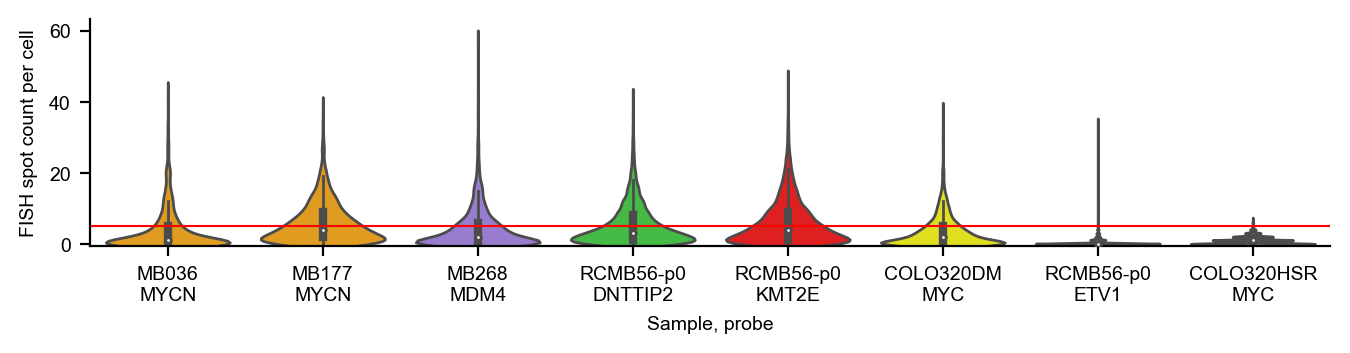

In [11]:
#df = read_long_all()
df = read_long_FFPE()
#df=df[df['target']!='ETV1']
plot_data = plot_fish_counts(df)
plt.savefig("out/violinplot-FISH-spots-per-cell-FFPE.svg")

INFO:read 4175 nuclei
INFO:4000 after removing outliers (z > 2)
INFO:read 3026 nuclei
INFO:2896 after removing outliers (z > 2)
INFO:read 2463 nuclei
INFO:2350 after removing outliers (z > 2)
INFO:read 15453 nuclei
INFO:14753 after removing outliers (z > 2)
INFO:read 5670 nuclei
INFO:5432 after removing outliers (z > 2)
INFO:read 3235 nuclei
INFO:3085 after removing outliers (z > 2)


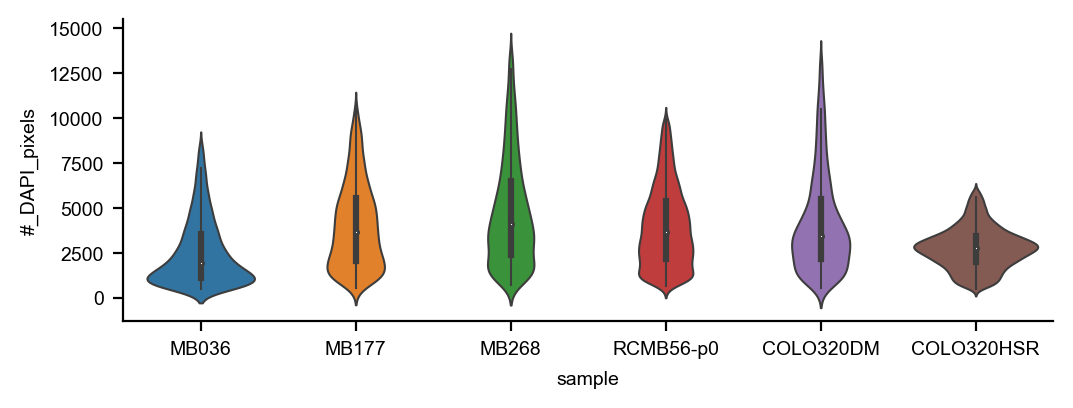

In [6]:
#df = read_wide_all()
df = read_wide_FFPE()
plot_data = plot_dapi_areas(df)
#plt.savefig("out/violinplot-DAPI-size-per-cell-FFPE.svg")

In [7]:
# What fraction of cells have CN > 2? > 10?
def fraction_amplified_nuclei(df,sample=None,target=None,cutoff=5):
    '''
    Assumes df has 3 columns: ['sample','target','value']
    '''
    if sample != None:
        df = df[df['sample'] == sample]
    if target != None:
        df = df[df['target'] == target]
    num = len(df[df.value > cutoff])
    denom = len(df)
    logging.info(f'{num} of {denom} nuclei in {sample} have {target} CN > {cutoff} ({round(num/denom*100)}%).')
    return (num,denom)

In [13]:
df = read_long_all()
fraction_amplified_nuclei(df,'MB036','MYCN')
fraction_amplified_nuclei(df,'MB177','MYCN')
fraction_amplified_nuclei(df,'MB268','MDM4')
fraction_amplified_nuclei(df,'RCMB56-p0','DNTTIP2')
fraction_amplified_nuclei(df,'RCMB56-p0','KMT2E')
fraction_amplified_nuclei(df,'RCMB56-p0','ETV1')
fraction_amplified_nuclei(df,'RCMB56_x1','DNTTIP2')
fraction_amplified_nuclei(df,'RCMB56_x1','KMT2E')
fraction_amplified_nuclei(df,'RCMB56_x1','ETV1')
fraction_amplified_nuclei(df,'COLO320DM','MYC')
fraction_amplified_nuclei(df,'COLO320HSR','MYC')

INFO:read 4175 nuclei
INFO:4000 after removing outliers (z > 2)
INFO:read 3026 nuclei
INFO:2896 after removing outliers (z > 2)
INFO:read 2463 nuclei
INFO:2350 after removing outliers (z > 2)
INFO:read 15453 nuclei
INFO:14753 after removing outliers (z > 2)
INFO:read 5670 nuclei
INFO:5432 after removing outliers (z > 2)
INFO:read 3235 nuclei
INFO:3085 after removing outliers (z > 2)
INFO:read 782 nuclei
INFO:744 after removing outliers (z > 2)
INFO:536 of 2350 nuclei in MB036 have MYCN CN > 5 (23%).
INFO:1181 of 2896 nuclei in MB177 have MYCN CN > 5 (41%).
INFO:1135 of 4000 nuclei in MB268 have MDM4 CN > 5 (28%).
INFO:5130 of 14753 nuclei in RCMB56-p0 have DNTTIP2 CN > 5 (35%).
INFO:6086 of 14753 nuclei in RCMB56-p0 have KMT2E CN > 5 (41%).
INFO:94 of 14753 nuclei in RCMB56-p0 have ETV1 CN > 5 (1%).
INFO:439 of 744 nuclei in RCMB56_x1 have DNTTIP2 CN > 5 (59%).
INFO:526 of 744 nuclei in RCMB56_x1 have KMT2E CN > 5 (71%).
INFO:398 of 744 nuclei in RCMB56_x1 have ETV1 CN > 5 (53%).
INFO:

(19, 5432)

In [89]:
# function to calculate Cohen's d for independent samples
def cohend(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = np.mean(d1), np.mean(d2)
    # calculate the effect size
    return (u1 - u2) / s
def plot_rcmb56_regions(df):
    '''
    Assumes df has 3 columns: ['sample','target','value']
    '''
    df=df.rename(columns={'value':'FISH spot count per cell'})
    df['Sample, probe']=df['sample']+'\n'+df['target']
    cols = len(df['Sample, probe'].unique())
    sf=0.75
    plt.rcParams["figure.figsize"] = (sf*cols,sf*2)
    palette=palette=['limegreen','red']
    ax = sns.violinplot(y=df['FISH spot count per cell'],x=df['target'],hue=df['sample'],
                        linewidth=sf,scale='width',palette=palette)
    #ax = sns.boxplot(y=df['FISH spot count per cell'],x=df['Sample, probe'])
    sns.despine()
    #plt.gca().set_yscale('log')
    plt.gca().set_ylim(bottom=-0.5)
    line = ax.axhline(y = 2, color = 'r', linestyle = '-')
    line.set_linewidth(0.75)
    
    # print statistics
    logging.info('Mean')
    logging.info(df.groupby('Sample, probe').mean())
    logging.info('Variance')
    logging.info(df.groupby('Sample, probe').var())
    
    # Mann-whitney tests
    test = scipy.stats.mannwhitneyu
    #test = scipy.stats.epps_singleton_2samp
    logging.info('Comparison DNTTIP2:')
    a=df[(df['sample']=='RCMB56_p1.2') & (df.target=='DNTTIP2')]['FISH spot count per cell']
    b=df[(df['sample']=='RCMB56_p1.3') & (df.target=='DNTTIP2')]['FISH spot count per cell']
    logging.info(test(a,b))
    logging.info(f"Cohen's d: {cohend(a,b)}")
    logging.info('Comparison KMT2E:')
    a=df[(df['sample']=='RCMB56_p1.2') & (df.target=='KMT2E')]['FISH spot count per cell']
    b=df[(df['sample']=='RCMB56_p1.3') & (df.target=='KMT2E')]['FISH spot count per cell']
    logging.info(test(a,b))
    logging.info(f"Cohen's d: {cohend(a,b)}")
    return plt.gcf()

INFO:read 15943 nuclei
INFO:15224 after removing outliers (z > 2)
INFO:read 17470 nuclei
INFO:16710 after removing outliers (z > 2)
INFO:Mean
INFO:                      FISH spot count per cell
Sample, probe                                 
RCMB56_p1.2\nDNTTIP2                  5.252484
RCMB56_p1.2\nKMT2E                    5.090844
RCMB56_p1.3\nDNTTIP2                  4.818576
RCMB56_p1.3\nKMT2E                    5.700276
INFO:Variance
INFO:                      FISH spot count per cell
Sample, probe                                 
RCMB56_p1.2\nDNTTIP2                 31.466741
RCMB56_p1.2\nKMT2E                   32.220606
RCMB56_p1.3\nDNTTIP2                 25.733752
RCMB56_p1.3\nKMT2E                   33.291425
INFO:Comparison DNTTIP2:
INFO:MannwhitneyuResult(statistic=130567819.5, pvalue=3.800948494715544e-05)
INFO:Cohen's d: 0.08094721726088702
INFO:Comparison KMT2E:
INFO:MannwhitneyuResult(statistic=116738721.5, pvalue=2.3411629105954385e-37)
INFO:Cohen's d: -0.106523398187

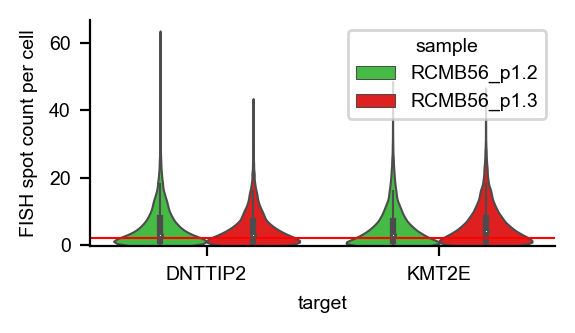

In [90]:
## Compare RCMB56-p1 region 1 to region 2
df = read_long_RCMB56_regions()
df = df[df.target != 'ETV1']
plot_data = plot_rcmb56_regions(df)
plt.savefig("out/violinplot-RCMB56-p1-regions.svg")

In [ ]:
plot_data[(plot_data.sample=='RCMB56_p1.2')]
#plot_data[(plot_data.sample=='RCMB56_p1.2') & (plot_data.target=='DNTTIP2')]['FISH spot count per cell']

In [69]:
plot_data[(plot_data['sample'] == 'RCMB56_p1.2') & (plot_data.target == 'DNTTIP2')]['FISH spot count per cell']

0         0
1         0
2        17
3        13
4         0
         ..
16705     3
16706     3
16707     0
16708     3
16709     0
Name: FISH spot count per cell, Length: 16710, dtype: int64

INFO:read 15943 nuclei
INFO:15224 after removing outliers (z > 2)
INFO:(0.5012974546057862, 0.0)


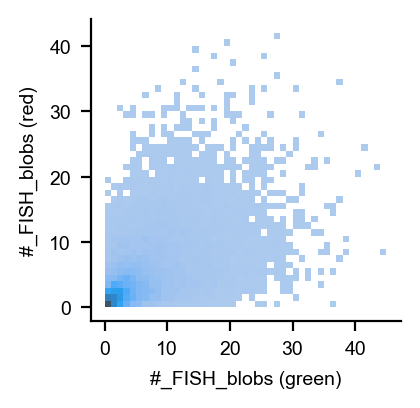

In [38]:
# Correlation between amplifications in the same cells
def correlate_amplifications(df,gene1='DNTTIP2',gene2='KMT2E'):
    '''
    df: wide form df. RCMB56 is the only sample we have with multiple amplifications.
    '''
    gene_map = {
        'DNTTIP2':'#_FISH_blobs (green)',
        'KMT2E':'#_FISH_blobs (red)',
        'ETV1':'#_FISH_blobs (aqua)'
    }
    x=df[gene_map[gene1]]
    y=df[gene_map[gene2]]
    
    plt.rcParams["figure.figsize"] = (2,2)
    sns.histplot(df,x=x,y=y,binwidth=1)
    sns.despine()
    
    # print stats
    logging.info(scipy.stats.pearsonr(x,y))
    return plt.gcf()
df = read_counts_RCMB56_p1_region3()
plot_data = correlate_amplifications(df)

In [55]:
plot_data

,sample,target,FISH spot count per cell,"Sample, probe"
0,RCMB56_p1.2,DNTTIP2,0,RCMB56_p1.2\nDNTTIP2
1,RCMB56_p1.2,DNTTIP2,0,RCMB56_p1.2\nDNTTIP2
2,RCMB56_p1.2,DNTTIP2,17,RCMB56_p1.2\nDNTTIP2
3,RCMB56_p1.2,DNTTIP2,13,RCMB56_p1.2\nDNTTIP2
4,RCMB56_p1.2,DNTTIP2,0,RCMB56_p1.2\nDNTTIP2
...,...,...,...,...
63863,RCMB56_p1.3,KMT2E,15,RCMB56_p1.3\nKMT2E
63864,RCMB56_p1.3,KMT2E,4,RCMB56_p1.3\nKMT2E
63865,RCMB56_p1.3,KMT2E,0,RCMB56_p1.3\nKMT2E
63866,RCMB56_p1.3,KMT2E,0,RCMB56_p1.3\nKMT2E


INFO:read 15943 nuclei
INFO:15224 after removing outliers (z > 2)
INFO:(0.23386979807441735, 7.28001938354856e-53)


4166


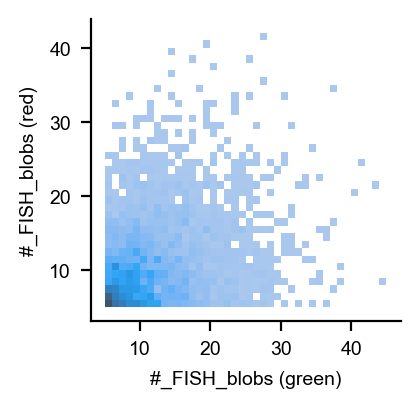

In [40]:
# Only amplified cells
df = read_counts_RCMB56_p1_region3()
df = df[(df['#_FISH_blobs (green)'] > 4) & (df['#_FISH_blobs (red)'] > 4)]
print(len(df))
plot_data = correlate_amplifications(df)
plt.savefig('out/scatter-FISH-DNTTIP2xKMT2E-correlation-CN4.svg')

INFO:read 15943 nuclei
INFO:15224 after removing outliers (z > 2)
INFO:(0.1206145497606473, 0.14561174139035798)


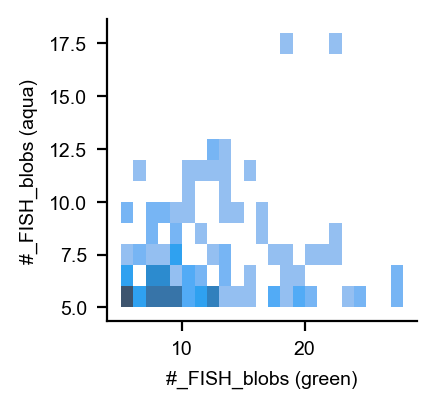

In [41]:
df = read_counts_RCMB56_p1_region3()
df = df[(df['#_FISH_blobs (green)'] > 4) & (df['#_FISH_blobs (aqua)'] > 4)]
plot_data = correlate_amplifications(df,gene2='ETV1')

INFO:read 15943 nuclei
INFO:15224 after removing outliers (z > 2)
INFO:(0.10130209111178279, 0.22373777567729425)


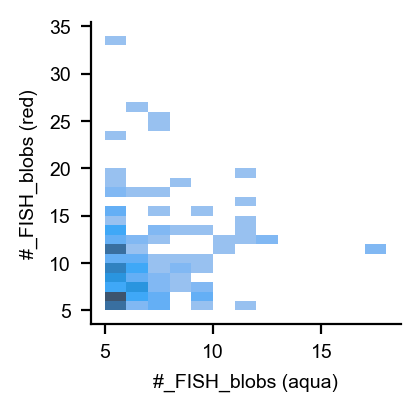

In [42]:
df = read_counts_RCMB56_p1_region3()
df = df[(df['#_FISH_blobs (aqua)'] > 4) & (df['#_FISH_blobs (red)'] > 4)]
plot_data = correlate_amplifications(df,gene1='ETV1')

INFO:read 15943 nuclei
INFO:15224 after removing outliers (z > 2)
INFO:(0.006589644974253295, 0.41621278579955906)


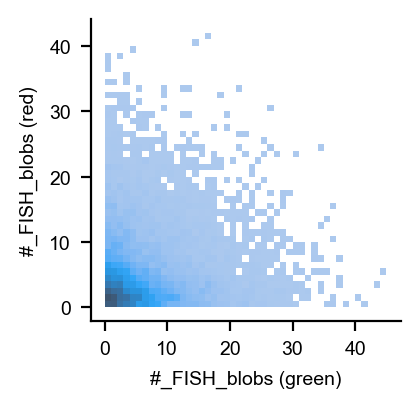

In [43]:
# Shuffle. Permute DNTTIP2 w.r.t. KMT2E.
## No correlation.
df = read_counts_RCMB56_p1_region3()
df['#_FISH_blobs (green)'] = np.random.permutation(df['#_FISH_blobs (green)'])
plot_data = correlate_amplifications(df)